In [28]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import mplfinance as mpf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks

[*********************100%%**********************]  1 of 1 completed


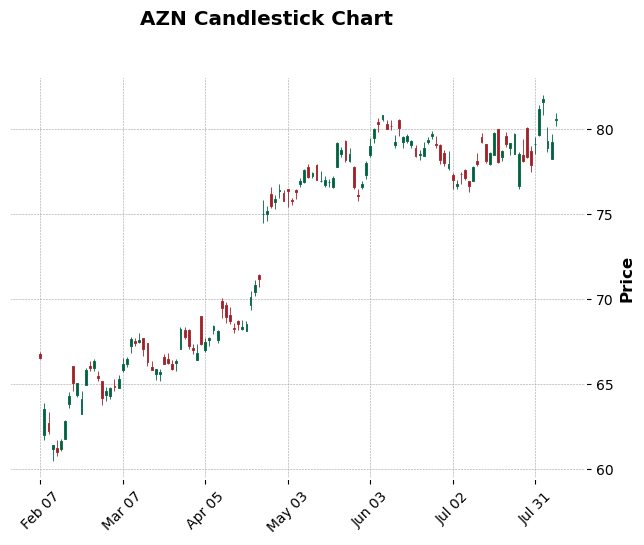

In [72]:

# Download recent data
recent_data = yf.download("AZN", period="6mo", interval="1d")

# Drop unnecessary columns
recent_data = recent_data.drop(columns=["Adj Close"])

# Create a candlestick chart
mpf.plot(
    recent_data,
    type="candle",
    style="charles",
    title="AZN Candlestick Chart",
    ylabel="Price",
)

# Show the plot
mpf.show()

In [79]:

X = recent_data.drop(columns=["Close","Volume"])
y = recent_data.drop(columns=["High","Low","Open"])
train_X,val_X,train_y,val_y = train_test_split(X,y,random_state = 1)
input_shape = [4]


early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)


model = keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])
model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)
EPOCHS = 1000
history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    batch_size=64,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=0,
)


In [77]:
checl_data =  yf.download("AZN",period= "1d") 
checl_data = checl_data.drop(columns=["Adj Close"])
check_X = checl_data.drop(columns=["Close","Volume"])
#print(checl_data.head())
print(check_X)
print(model.predict(check_X))

[*********************100%%**********************]  1 of 1 completed

             Open       High        Low
Date                                   
2024-08-07  80.57  80.985001  80.199997
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[[391.43063]]


In [78]:
print(X)

                 Open       High        Low
Date                                       
2024-02-07  66.769997  66.900002  66.489998
2024-02-08  62.020000  63.900002  61.700001
2024-02-09  62.709999  63.369999  62.080002
2024-02-12  61.160000  61.439999  60.470001
2024-02-13  61.250000  61.700001  60.759998
...               ...        ...        ...
2024-08-01  79.650002  81.400002  79.620003
2024-08-02  81.599998  82.010002  80.830002
2024-08-05  78.879997  80.129997  78.690002
2024-08-06  78.250000  79.730003  78.220001
2024-08-07  80.570000  80.985001  80.199997

[126 rows x 3 columns]


In [70]:
recent_data = yf.download("AZN", period="6mo", interval="1d")
recent_data.index

[*********************100%%**********************]  1 of 1 completed


DatetimeIndex(['2024-02-07', '2024-02-08', '2024-02-09', '2024-02-12',
               '2024-02-13', '2024-02-14', '2024-02-15', '2024-02-16',
               '2024-02-20', '2024-02-21',
               ...
               '2024-07-25', '2024-07-26', '2024-07-29', '2024-07-30',
               '2024-07-31', '2024-08-01', '2024-08-02', '2024-08-05',
               '2024-08-06', '2024-08-07'],
              dtype='datetime64[ns]', name='Date', length=126, freq=None)